In [4]:
from IRDataAnal import *
%load_ext autoreload
%autoreload 2

In [5]:
import matplotlib as mpl

mpl.rcParams['axes.linewidth'] = 1.4
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.bottom'] = True
plt.rcParams["axes.labelweight"] = "bold"

mpl.rcParams['figure.dpi'] = 400

mpl.rcParams['font.size'] = 8
mpl.rcParams["font.weight"] = "bold"

In [6]:
from colour import Color

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Ridge

from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

import itertools
from sklearn.metrics import mean_absolute_error

In [8]:
ir = calibrationData('../hplc and IR data/IR data/', '../hplc and IR data/HPLC data for training/', ['prod (M)'])

Loading IR data......
ac0089-1
ac0089-2
ac0089-3
ac0091-1
ac0091-2
ac0091-4
ac0091-5
Loading LC data......
ac0089-1.xlsx
ac0089-2.xlsx
ac0089-3.xlsx
ac0091-1.xlsx
ac0091-2.xlsx
ac0091-4.xlsx
ac0091-5.xlsx


In [12]:
subtract_list = [14,13,10,8,10,11,13]

In [14]:
# include_steady_state = [True, False]
is_decimate = [True, False]
# is_maxhyperparam = [True, False  # actually this is not necessery
is_fullregion = [[], [[160, 186]]]  
derivatives = [0, 2]
is_truncate_ss = [20, False]

overall_score = []
lvs_list = []
overall_counter = 0

for test_index in test_index_list: 
    counter = 0
    temp_score = []
    temp_lvs = []
    for dec in is_decimate: 
        for reg in is_fullregion: 
            for der in derivatives: 
                for ss in is_truncate_ss: 
                    ir.preprocess([280], [540], isTruncateData=None, isSubtractAny=[], 
                                  isSNV=None, isDerivative=der, truncateWaveNUmber=reg)
                    
                    ir.trainTestSplit(test_index, [])

                    if ss: 
                        temp_ir, temp_lc = [], []
                        s, e = 0, ir.train_dataLList[0]
                        for i in range(len(ir.train_dataLList)): 
                            temp_ir.append(ir.train_ir[s:s+ss, :])
                            temp_lc.append(ir.train_lc[s:s+ss, :])

                            s = e
                            if i == len(ir.train_dataLList) - 1: 
                                e = -1
                            else: 
                                e = e + ir.train_dataLList[i+1]

                        ir.train_ir = np.vstack(temp_ir)
                        ir.train_lc = np.vstack(temp_lc)

                    if dec: 
                        ir.train_ir = ir.train_ir[::2, :]
                        ir.train_lc = ir.train_lc[::2, :]
                    
                    X_train, X_test, y_train, y_test = train_test_split(ir.train_ir, ir.train_lc,
                                            test_size=0.001, random_state=555, shuffle=True)
                    if reg: 
                        lvs = np.arange(2, 20)
                    else: 
                        lvs = np.arange(2, 30)
                    paramters = {'n_components':lvs}
                    rgr = PLSRegression()
                    clf = GridSearchCV(rgr, paramters, scoring='neg_mean_absolute_error', cv=5)
                    clf.fit(X_train, y_train)
                    best_lv = lvs[np.argmax(clf.cv_results_['mean_test_score'])]
                    # else: 
                    #     best_lv_ind = np.where(np.abs(np.diff(clf.cv_results_['mean_test_score'])) < 
                    #      (np.mean(np.abs(np.diff(clf.cv_results_['mean_test_score']))[-10:])+
                    #       1.5*np.std(np.abs(np.diff(clf.cv_results_['mean_test_score']))[-10:])))[0][0]
                    #     best_lv = lvs[best_lv_ind]
                        
                    temp_lvs.append(best_lv)
                    rgr = PLSRegression(best_lv)
                    rgr.fit(ir.train_ir, ir.train_lc)
                    pred = rgr.predict(ir.test_ir)
                    temp_score.append(mean_absolute_error(ir.test_lc, pred))
                    print(overall_counter, counter, dec, reg, der, ss)
                    counter += 1
                        
    overall_score.append(temp_score)
    lvs_list.append(temp_lvs)
    overall_counter += 1

0 0 True [] 0 20
0 1 True [] 0 False
0 2 True [] 2 20
0 3 True [] 2 False
0 4 True [[160, 186]] 0 20
0 5 True [[160, 186]] 0 False
0 6 True [[160, 186]] 2 20
0 7 True [[160, 186]] 2 False
0 8 False [] 0 20
0 9 False [] 0 False
0 10 False [] 2 20
0 11 False [] 2 False
0 12 False [[160, 186]] 0 20
0 13 False [[160, 186]] 0 False
0 14 False [[160, 186]] 2 20
0 15 False [[160, 186]] 2 False
1 0 True [] 0 20
1 1 True [] 0 False
1 2 True [] 2 20
1 3 True [] 2 False
1 4 True [[160, 186]] 0 20
1 5 True [[160, 186]] 0 False
1 6 True [[160, 186]] 2 20
1 7 True [[160, 186]] 2 False
1 8 False [] 0 20
1 9 False [] 0 False
1 10 False [] 2 20
1 11 False [] 2 False
1 12 False [[160, 186]] 0 20
1 13 False [[160, 186]] 0 False
1 14 False [[160, 186]] 2 20
1 15 False [[160, 186]] 2 False
2 0 True [] 0 20
2 1 True [] 0 False
2 2 True [] 2 20
2 3 True [] 2 False
2 4 True [[160, 186]] 0 20
2 5 True [[160, 186]] 0 False
2 6 True [[160, 186]] 2 20
2 7 True [[160, 186]] 2 False
2 8 False [] 0 20
2 9 False [] 0

In [17]:
def averageEffects(score_list, effect_index):
    
    n_res = len(score_list)
    ypos, yneg = [], []
    inc = int(n_res / (2**(effect_index)))
    pos_start, pos_end, neg_start, neg_end = 0, inc, inc, inc*2
    neg_end_i = inc*2
    for i in range(2**(effect_index-1)): 
        
        ypos.append(score_list[pos_start:pos_end])
        yneg.append(score_list[neg_start:neg_end])
        
        pos_start += neg_end_i
        pos_end += neg_end_i
        neg_start += neg_end_i
        neg_end += neg_end_i

    return np.array(ypos), np.array(yneg)

In [20]:
overall_effects = []
for i in range(35): 
    temp_effects = []
    for j in range(4): 
        ypos, yneg = averageEffects(overall_score[i, :], j+1)
        effects = np.log(ypos.mean()) - np.log(yneg.mean())
        temp_effects.append(effects)
    overall_effects.append(temp_effects)

In [21]:
overall_effects = np.array(overall_effects)

In [22]:
overall_effects.shape

(35, 4)

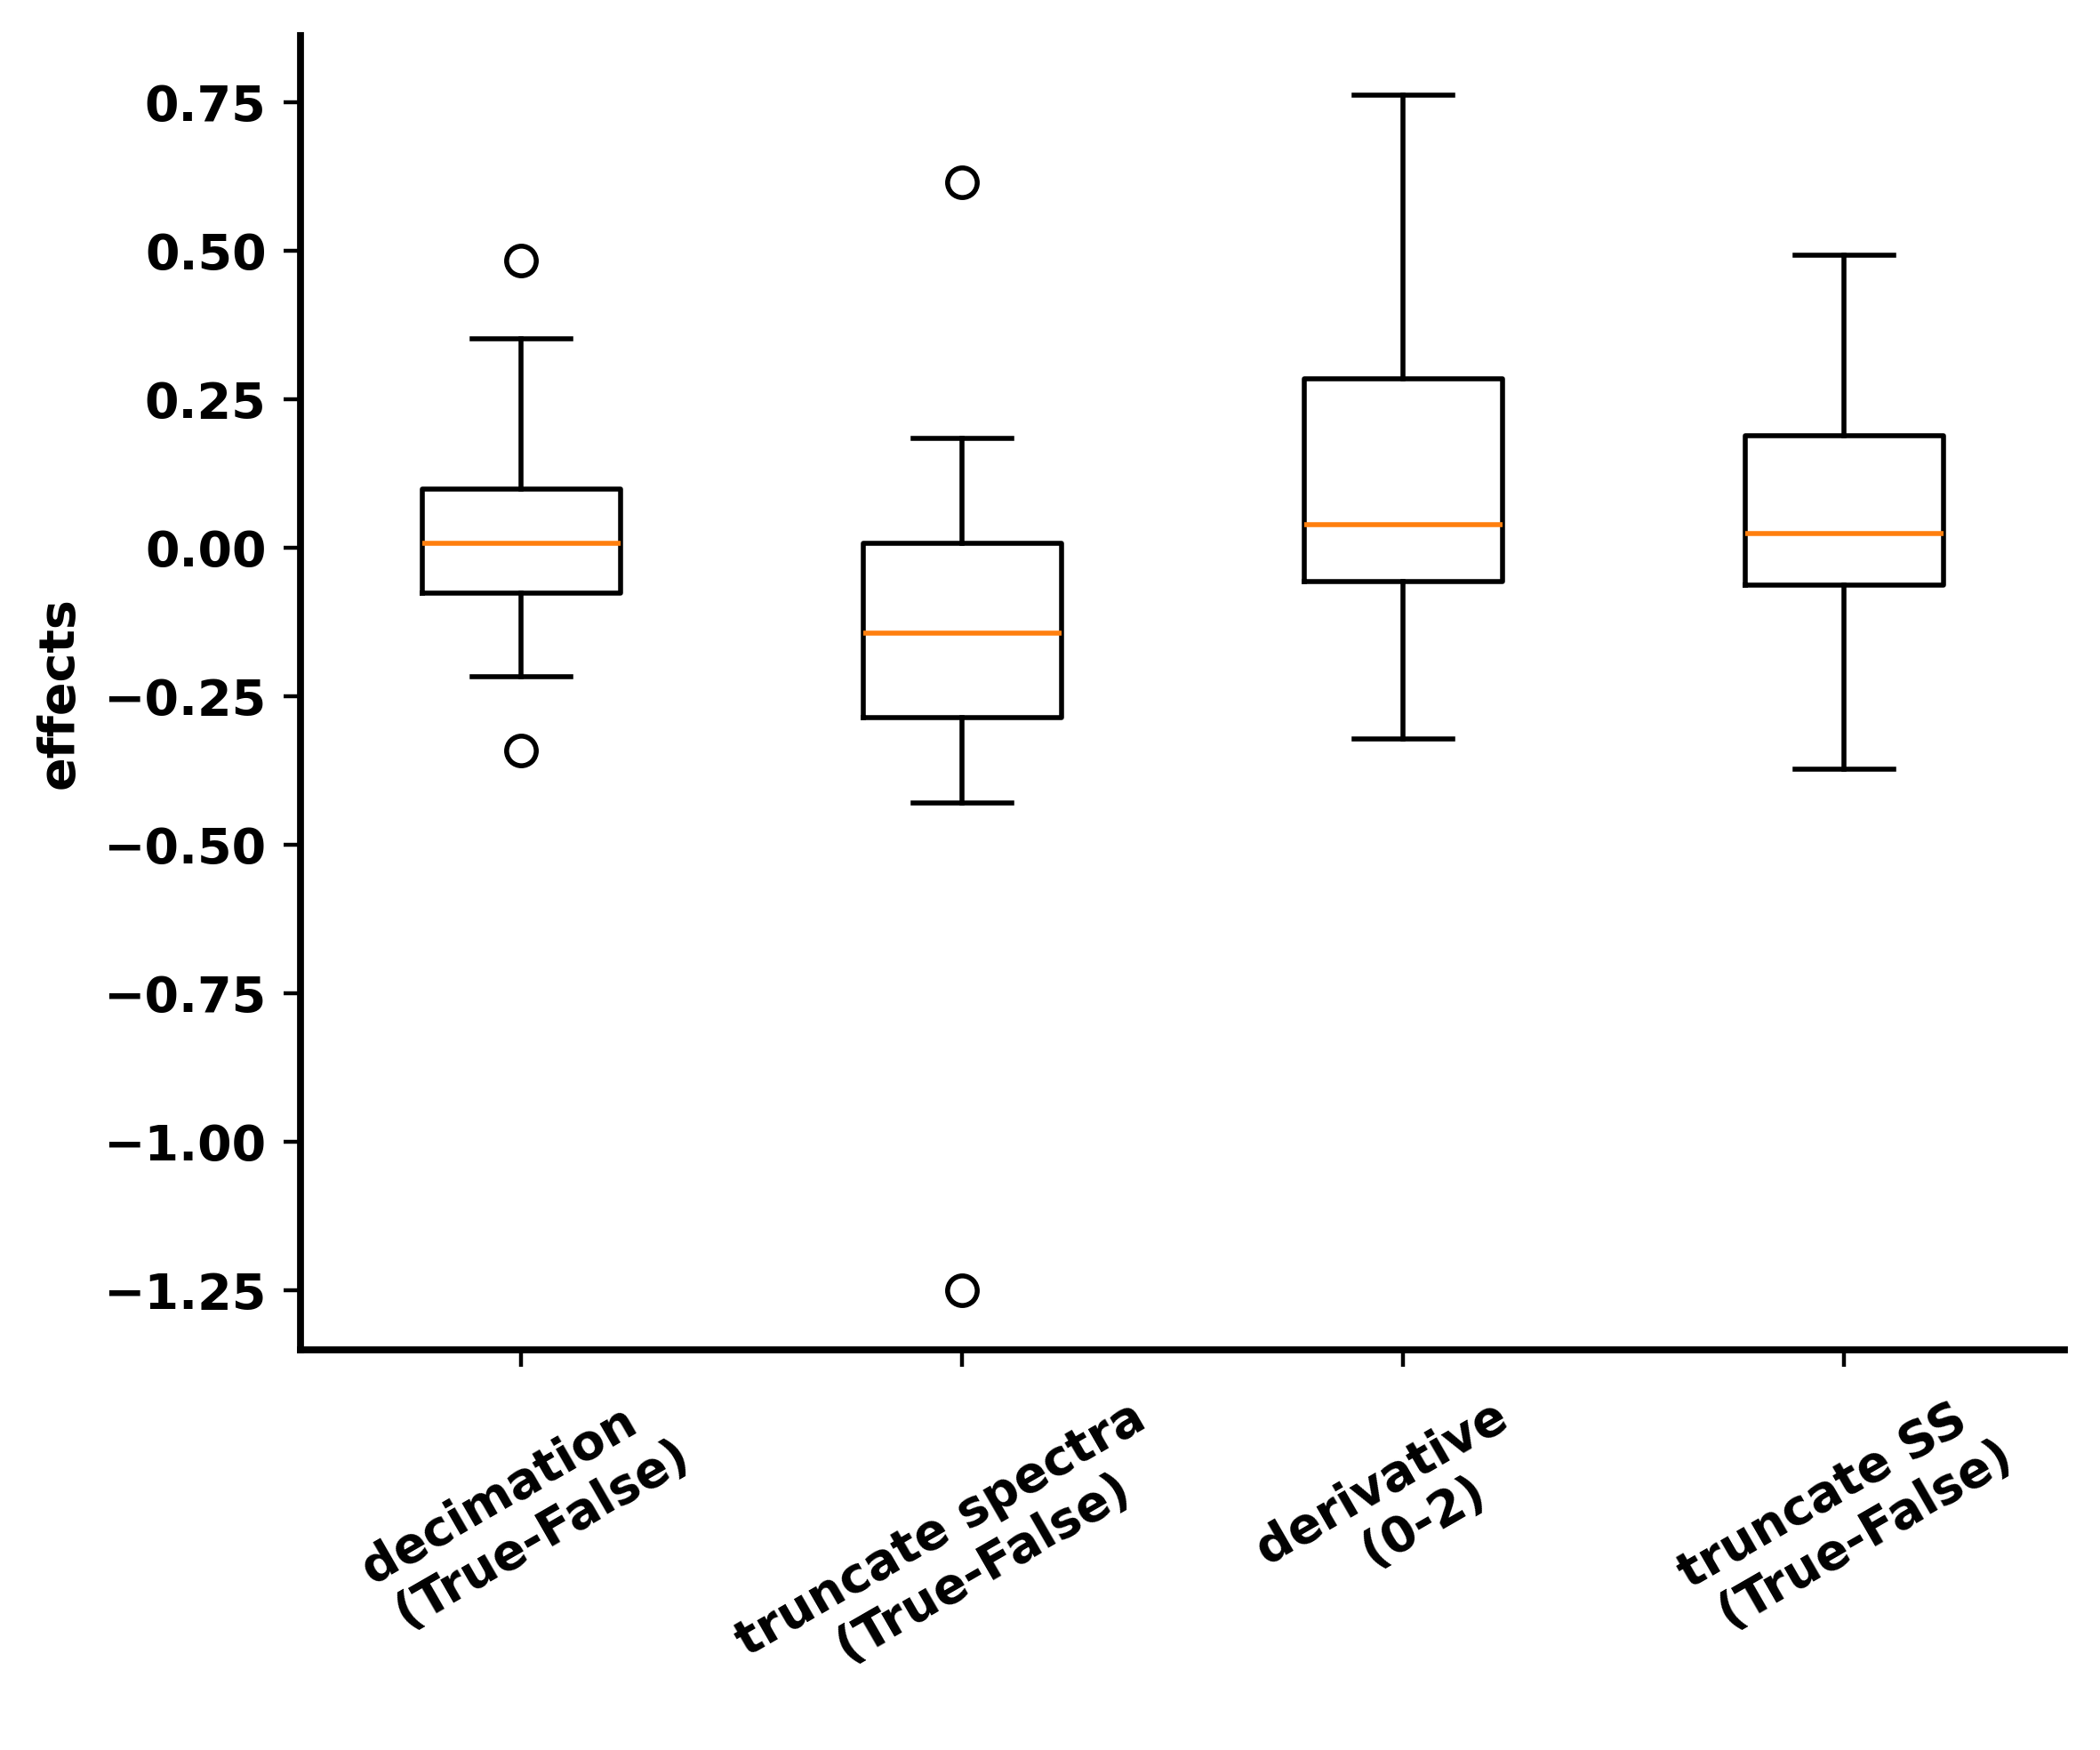

In [172]:
# repeat 35
mpl.rcParams['font.size'] = 10

labels = ['decimation \n (True-False)', 'truncate spectra \n (True-False)', 'derivative \n (0-2)', 'truncate SS \n (True-False)']
plt.boxplot(overall_effects)
plt.xticks(ticks=[1, 2, 3, 4], labels=labels, rotation=30);
plt.ylabel('effects');

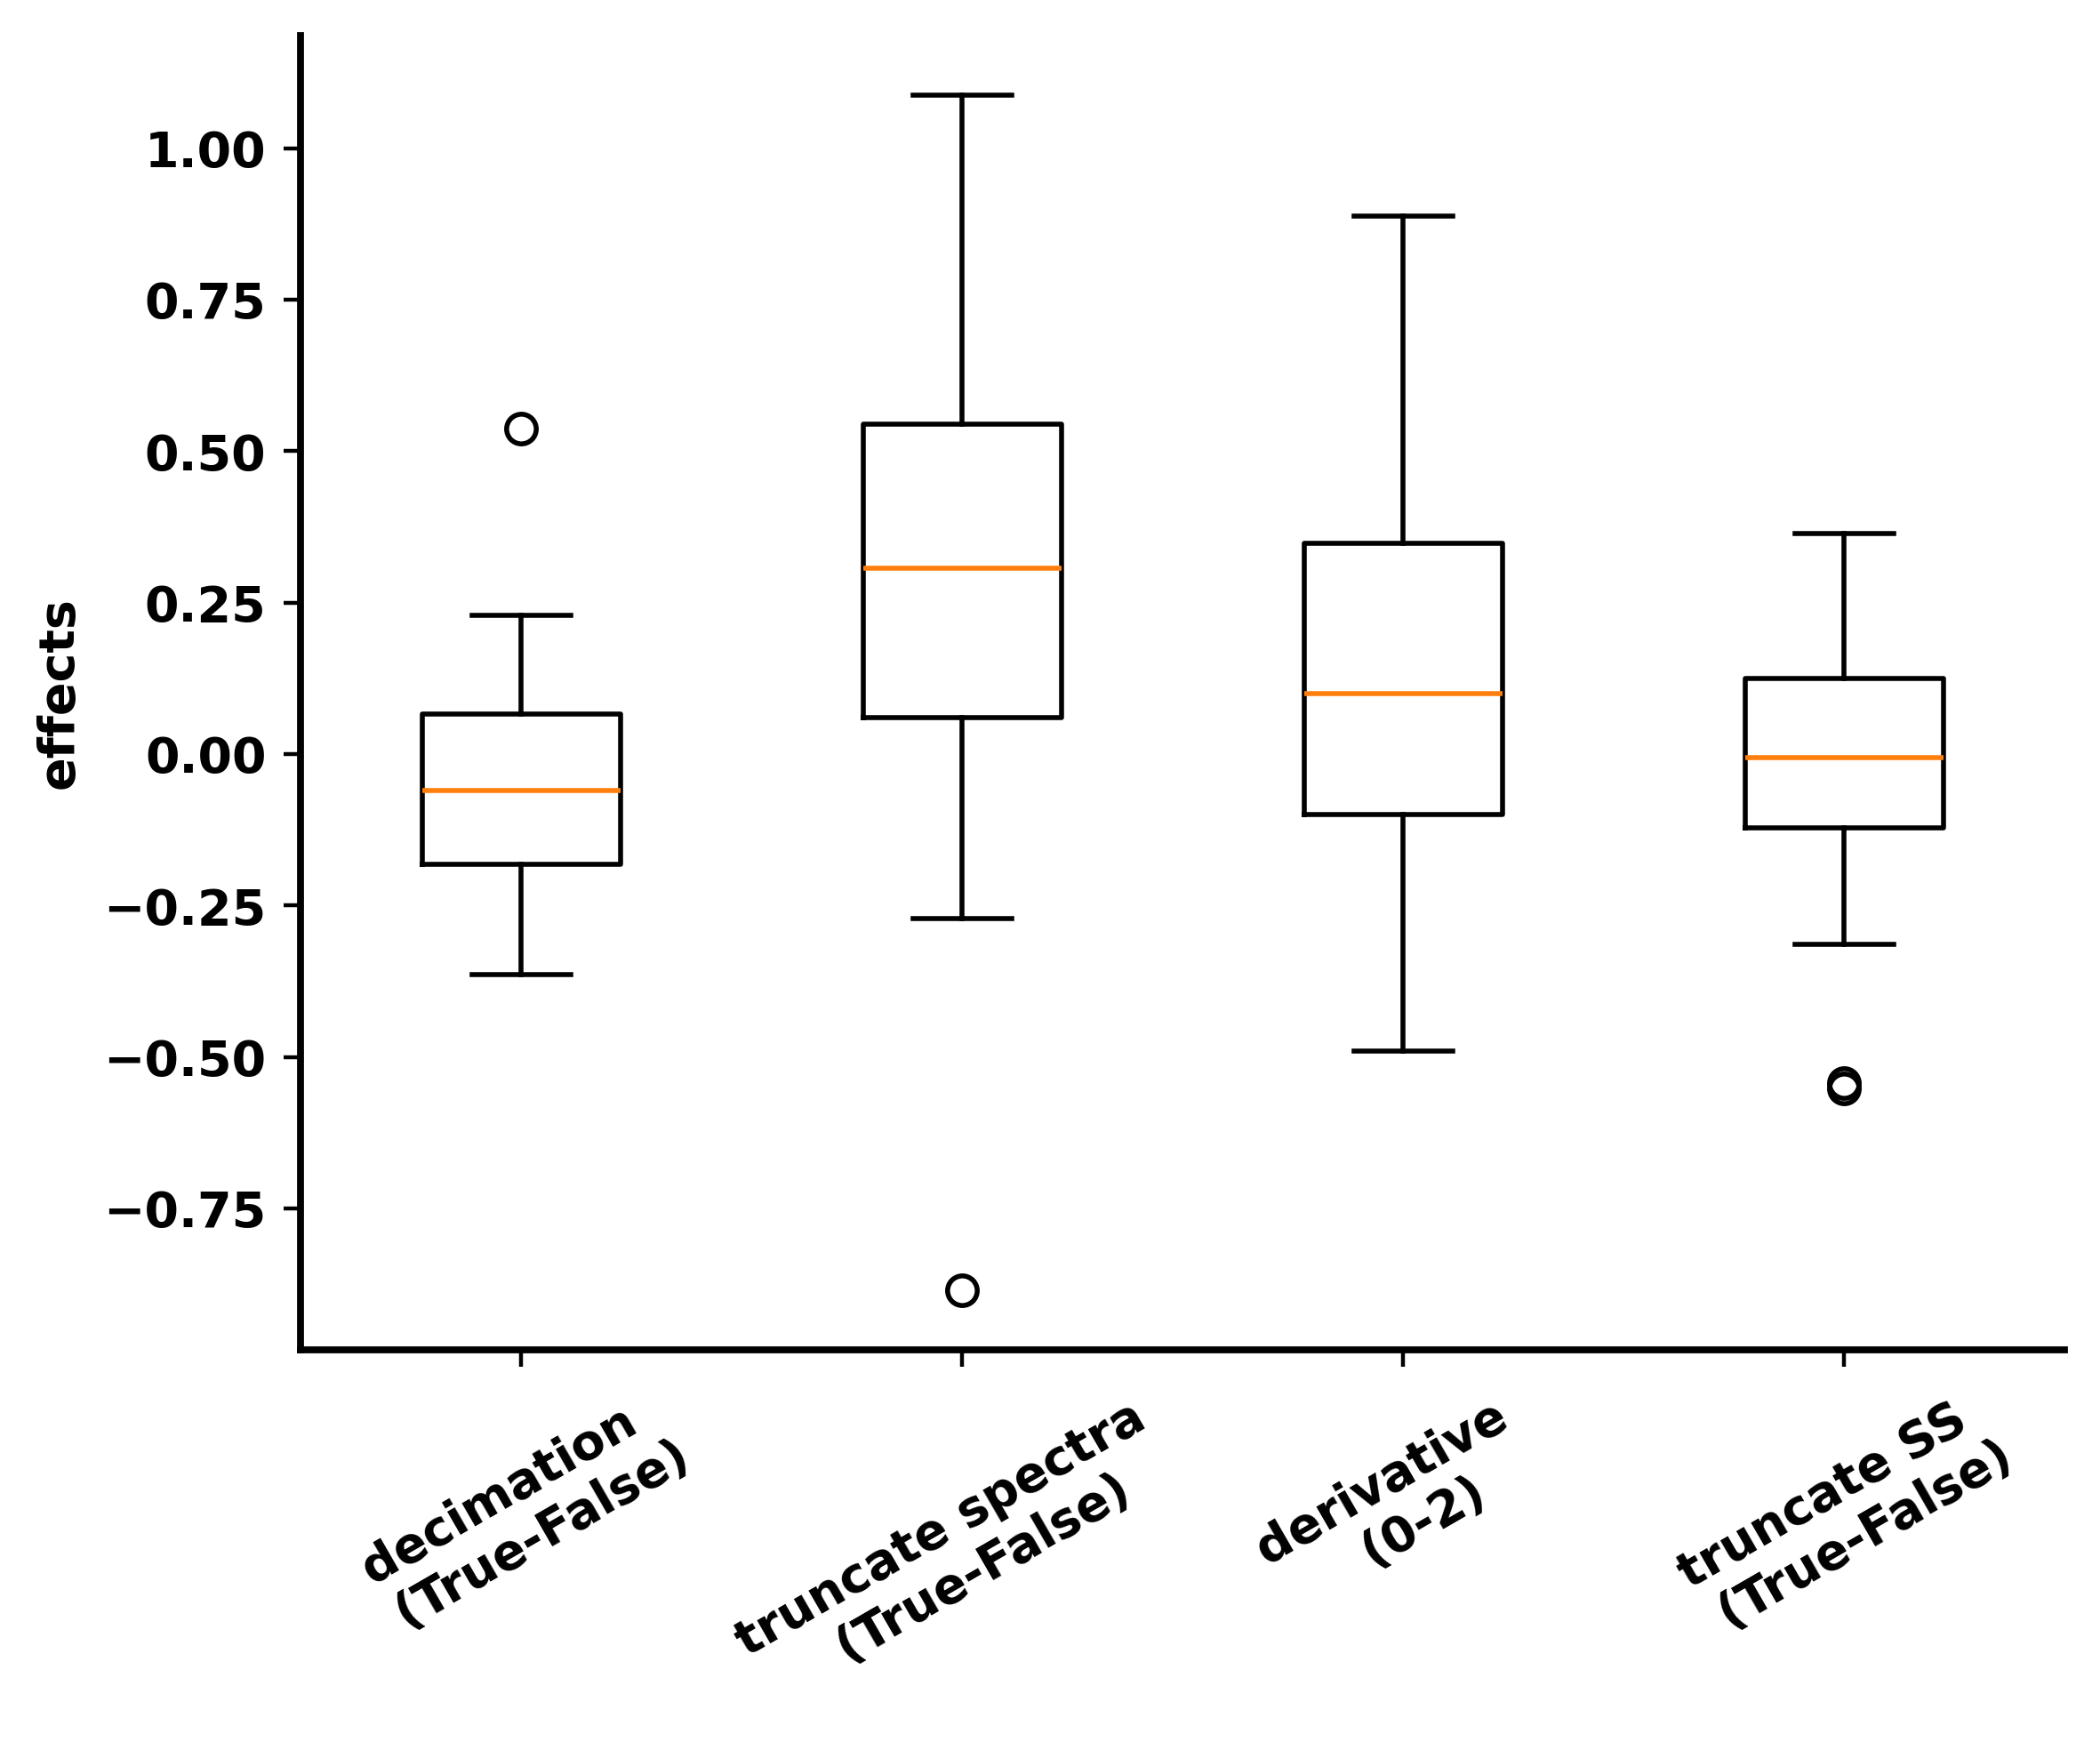

In [205]:
# repeat 35
mpl.rcParams['font.size'] = 10

labels = ['decimation \n (True-False)', 'truncate spectra \n (True-False)', 'derivative \n (0-2)', 'truncate SS \n (True-False)']
plt.boxplot(overall_effects)
plt.xticks(ticks=[1, 2, 3, 4], labels=labels, rotation=30);
plt.ylabel('effects');

(-1.0, 1.0)

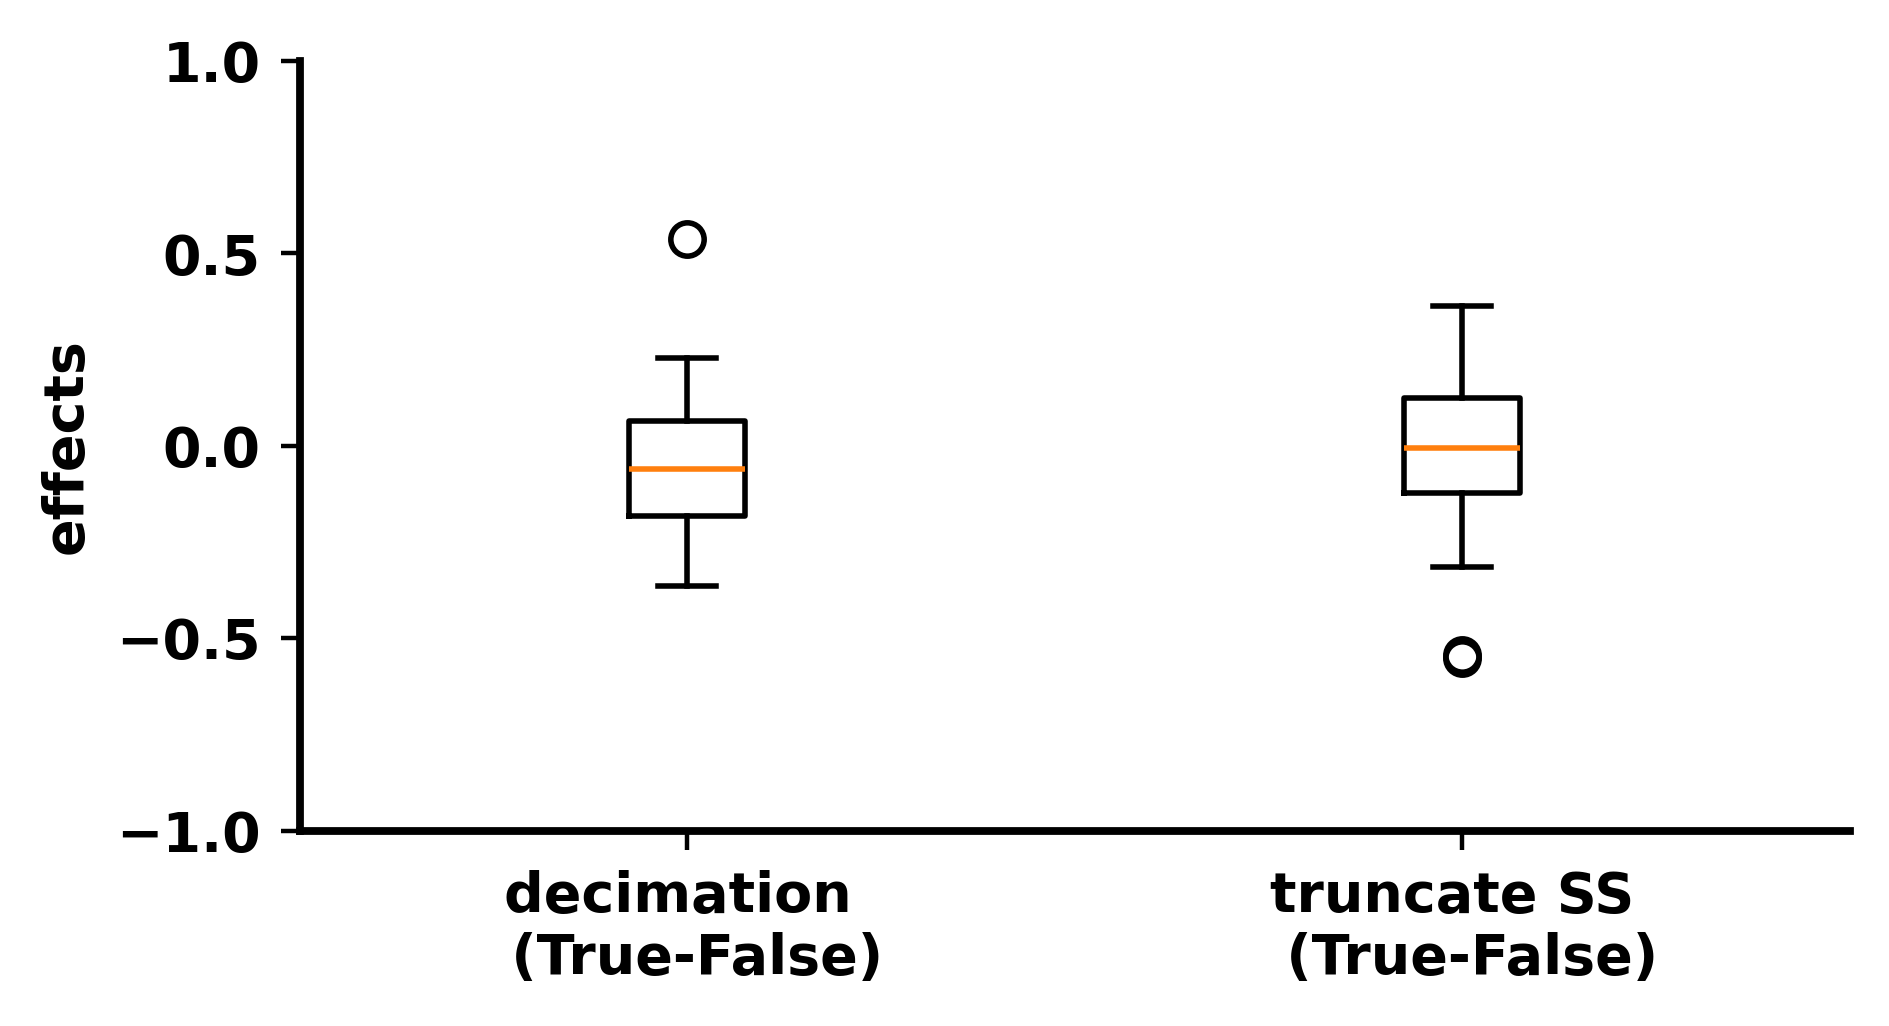

In [23]:
# repeat 35
plt.figure(figsize=(5, 2.5))
mpl.rcParams['font.size'] = 10

labels = ['decimation \n (True-False)', 'truncate SS \n (True-False)']
plt.boxplot(overall_effects[:, [0, -1]])
plt.xticks(ticks=[1, 2], labels=labels);
plt.ylabel('effects');
plt.ylim(-1, 1)

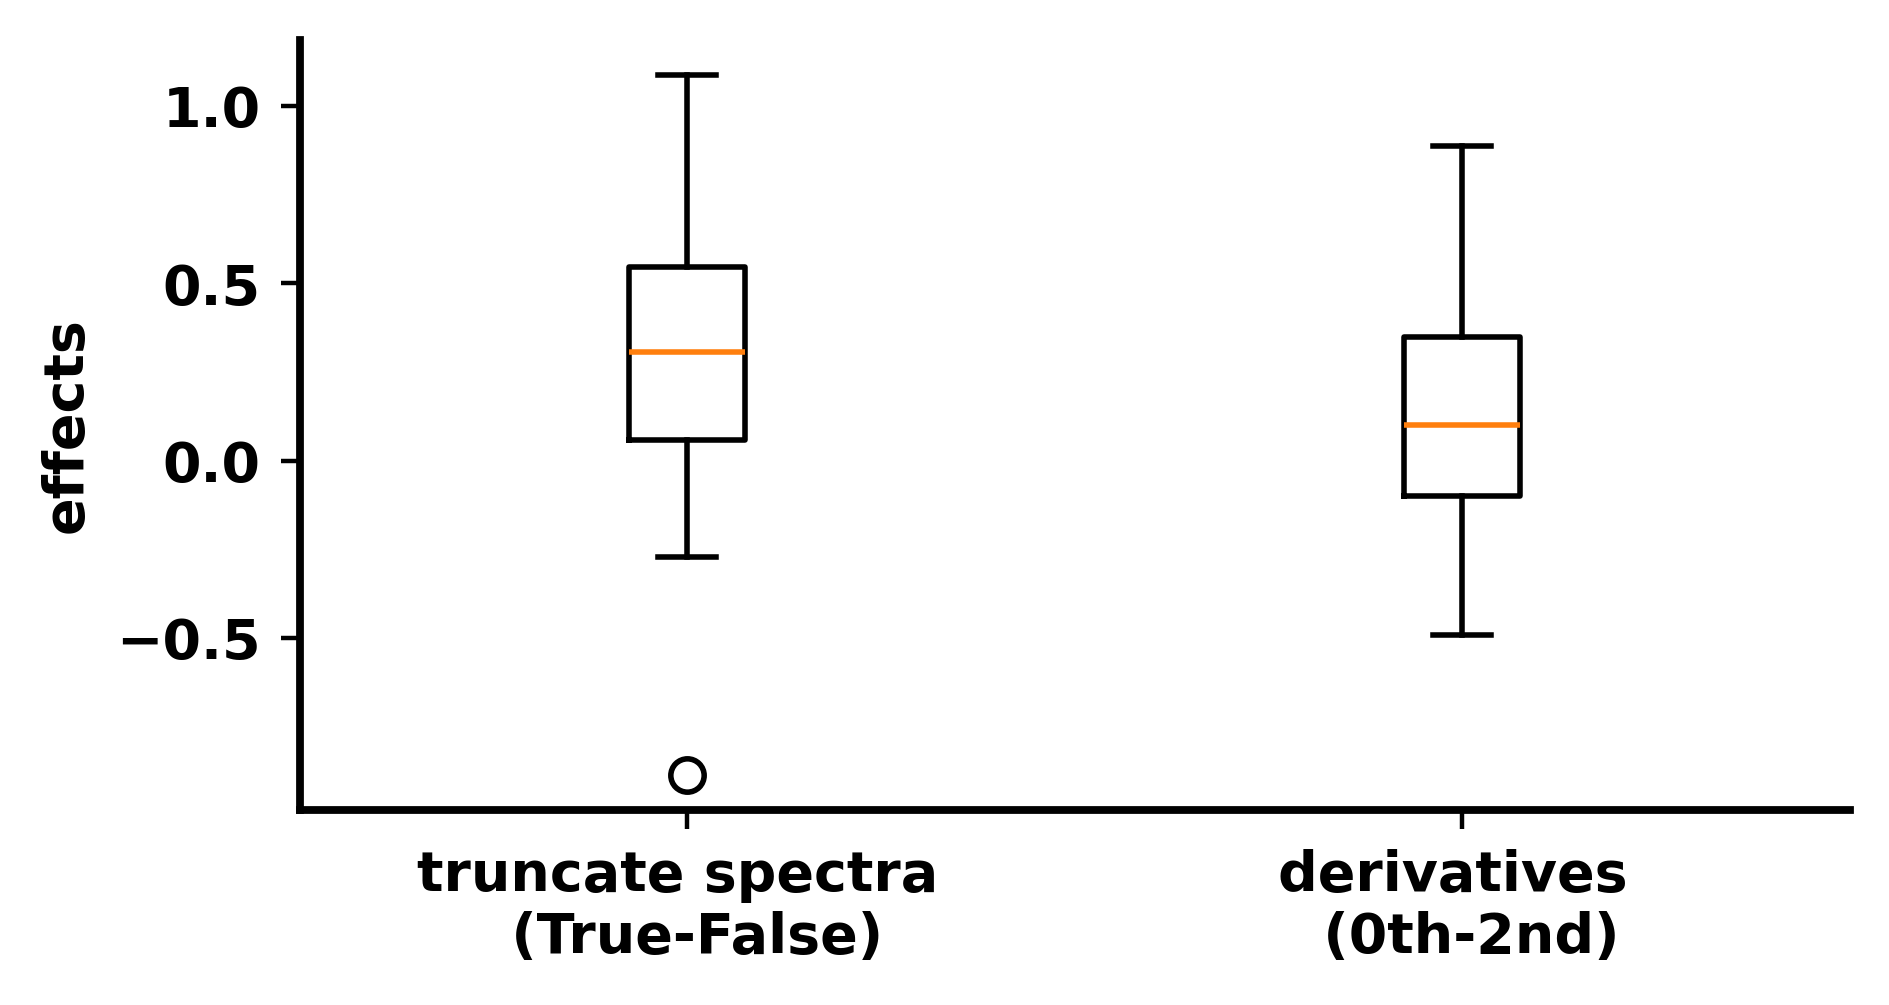

In [24]:
# repeat 35
plt.figure(figsize=(5, 2.5))
mpl.rcParams['font.size'] = 10

labels = ['truncate spectra \n (True-False)', 'derivatives \n (0th-2nd)']
plt.boxplot(overall_effects[:, [1, 2]])
plt.xticks(ticks=[1, 2], labels=labels);
plt.ylabel('effects');
# plt.ylim(-1, 1)